<a href="https://colab.research.google.com/github/gauriagarwal18/NYC-Taxi-Trip-Time-Prediction/blob/master/NYC_Taxi_Trip_Time_Prediction_Capstone_Project.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# <b><u> Project Title : Taxi trip time Prediction : Predicting total ride duration of taxi trips in New York City</u></b>

## <b> Problem Description </b>

### Your task is to build a model that predicts the total ride duration of taxi trips in New York City. Your primary dataset is one released by the NYC Taxi and Limousine Commission, which includes pickup time, geo-coordinates, number of passengers, and several other variables.

##We are using the following libraries for analysis:
- Numpy: We will use numpy arrays as they are comparitively faster than lists, also columns of dataframes behaves as numpy arrays

- Pandas: for reading the data from csv file, for data clening and for preparing data for analysis

- matplotlib,seaborn: for different visualisations, for drawing conclusions from data and for exploratory data analysis. 

In [2]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

##Loading CSV file from google drive in colab enviroment
We will first load our csv file in which data is stored to the colab enviroment in data frame format so that we can make the copy of the original data and perform the required cleaning and analysis on that data without changing the original one.



In [3]:
#Download datasets Hepatitis automobile from UCI repository
from google.colab import drive
drive.mount('/content/drive')
import os
path="/content/drive/My Drive/AlmaBetter_Capstone_projects/Capstone_project2_ml/NYC_TaxiData.csv"
taxi_original=pd.read_csv(path,parse_dates=[2,3])
taxi= taxi_original.copy()

Mounted at /content/drive


In [4]:
#shape of the data
taxi.shape

(1458644, 11)

In [5]:
taxi.head()

,id,vendor_id,pickup_datetime,dropoff_datetime,passenger_count,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,store_and_fwd_flag,trip_duration
0,id2875421,2,2016-03-14 17:24:55,2016-03-14 17:32:30,1,-73.982155,40.767937,-73.964630,40.765602,N,455
1,id2377394,1,2016-06-12 00:43:35,2016-06-12 00:54:38,1,-73.980415,40.738564,-73.999481,40.731152,N,663
2,id3858529,2,2016-01-19 11:35:24,2016-01-19 12:10:48,1,-73.979027,40.763939,-74.005333,40.710087,N,2124
3,id3504673,2,2016-04-06 19:32:31,2016-04-06 19:39:40,1,-74.010040,40.719971,-74.012268,40.706718,N,429
4,id2181028,2,2016-03-26 13:30:55,2016-03-26 13:38:10,1,-73.973053,40.793209,-73.972923,40.782520,N,435


## <b> Data Description </b>

### The dataset is based on the 2016 NYC Yellow Cab trip record data made available in Big Query on Google Cloud Platform. The data was originally published by the NYC Taxi and Limousine Commission (TLC). The data was sampled and cleaned for the purposes of this project. Based on individual trip attributes, you should predict the duration of each trip in the test set.

### <b>NYC Taxi Data.csv</b> - the training set (contains 1458644 trip records)


### Data fields
* #### id - a unique identifier for each trip
* #### vendor_id - a code indicating the provider associated with the trip record
* #### pickup_datetime - date and time when the meter was engaged
* #### dropoff_datetime - date and time when the meter was disengaged
* #### passenger_count - the number of passengers in the vehicle (driver entered value)
* #### pickup_longitude - the longitude where the meter was engaged
* #### pickup_latitude - the latitude where the meter was engaged
* #### dropoff_longitude - the longitude where the meter was disengaged
* #### dropoff_latitude - the latitude where the meter was disengaged
* #### store_and_fwd_flag - This flag indicates whether the trip record was held in vehicle memory before sending to the vendor because the vehicle did not have a connection to the server - Y=store and forward; N=not a store and forward trip
* #### trip_duration - duration of the trip in seconds

In [6]:
taxi.info()
"""
here we note that there is not any null value in data right now
"""

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1458644 entries, 0 to 1458643
Data columns (total 11 columns):
 #   Column              Non-Null Count    Dtype         
---  ------              --------------    -----         
 0   id                  1458644 non-null  object        
 1   vendor_id           1458644 non-null  int64         
 2   pickup_datetime     1458644 non-null  datetime64[ns]
 3   dropoff_datetime    1458644 non-null  datetime64[ns]
 4   passenger_count     1458644 non-null  int64         
 5   pickup_longitude    1458644 non-null  float64       
 6   pickup_latitude     1458644 non-null  float64       
 7   dropoff_longitude   1458644 non-null  float64       
 8   dropoff_latitude    1458644 non-null  float64       
 9   store_and_fwd_flag  1458644 non-null  object        
 10  trip_duration       1458644 non-null  int64         
dtypes: datetime64[ns](2), float64(4), int64(3), object(2)
memory usage: 122.4+ MB


'\nhere we note that there is not any null value in data right now\n'

In [7]:
taxi.shape

(1458644, 11)

In [8]:
taxi.describe(include="all")

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: FutureWarning: Treating datetime data as categorical rather than numeric in `.describe` is deprecated and will be removed in a future version of pandas. Specify `datetime_is_numeric=True` to silence this warning and adopt the future behavior now.
  """Entry point for launching an IPython kernel.


,id,vendor_id,pickup_datetime,dropoff_datetime,passenger_count,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,store_and_fwd_flag,trip_duration
count,1458644,1.458644e+06,1458644,1458644,1.458644e+06,1.458644e+06,1.458644e+06,1.458644e+06,1.458644e+06,1458644,1.458644e+06
unique,1458644,NaN,1380222,1380377,NaN,NaN,NaN,NaN,NaN,2,NaN
top,id2875421,NaN,2016-03-04 08:07:34,2016-02-19 19:25:04,NaN,NaN,NaN,NaN,NaN,N,NaN
freq,1,NaN,5,5,NaN,NaN,NaN,NaN,NaN,1450599,NaN
first,NaN,NaN,2016-01-01 00:00:17,2016-01-01 00:03:31,NaN,NaN,NaN,NaN,NaN,NaN,NaN
last,NaN,NaN,2016-06-30 23:59:39,2016-07-01 23:02:03,NaN,NaN,NaN,NaN,NaN,NaN,NaN
mean,NaN,1.534950e+00,NaN,NaN,1.664530e+00,-7.397349e+01,4.075092e+01,-7.397342e+01,4.075180e+01,NaN,9.594923e+02
std,NaN,4.987772e-01,NaN,NaN,1.314242e+00,7.090186e-02,3.288119e-02,7.064327e-02,3.589056e-02,NaN,5.237432e+03
min,NaN,1.000000e+00,NaN,NaN,0.000000e+00,-1.219333e+02,3.435970e+01,-1.219333e+02,3.218114e+01,NaN,1.000000e+00
25%,NaN,1.000000e+00,NaN,NaN,1.000000e+00,-7.399187e+01,4.073735e+01,-7.399133e+01,4.073588e+01,NaN,3.970000e+02


In [9]:
taxi.columns

Index(['id', 'vendor_id', 'pickup_datetime', 'dropoff_datetime',
       'passenger_count', 'pickup_longitude', 'pickup_latitude',
       'dropoff_longitude', 'dropoff_latitude', 'store_and_fwd_flag',
       'trip_duration'],
      dtype='object')

In [10]:
categorical=["vendor_id","passenger_count","store_and_fwd_flag"]
continuous=['pickup_longitude', 'pickup_latitude','dropoff_longitude', 'dropoff_latitude','trip_duration']
for c in categorical:
  print(f"distribution of {c}:\n{taxi[c].value_counts()}\n\n")

distribution of vendor_id:
2    780302
1    678342
Name: vendor_id, dtype: int64


distribution of passenger_count:
1    1033540
2     210318
5      78088
3      59896
6      48333
4      28404
0         60
7          3
9          1
8          1
Name: passenger_count, dtype: int64


distribution of store_and_fwd_flag:
N    1450599
Y       8045
Name: store_and_fwd_flag, dtype: int64




In [13]:
"""
The column drop off time is a dependent column, as drop off time will depend on trip time 
also triptime= dropoff time-pickup time, so it is of no use so we remove that feature
"""
taxi.drop(["dropoff_datetime"],inplace=True,axis=1)

In [14]:
"""
from above we note that some records have passenger count as 0,so those records are of no use so lets remove them.
"""
passenger_0=np.where(taxi["passenger_count"]==0)
taxi.drop(passenger_0[0], inplace = True)
taxi.shape

(1458584, 10)

In [15]:
def print_null_percent(df):
  null_percent=pd.Series()
  for col in df.columns:
    null_percent[col]=((df.shape[0]-df[col].count())/(df.shape[0]))*100
  print("columns with null values\n",null_percent[null_percent!=0])



In [16]:
from scipy import stats
def remove_outliers(df):

  continuous_col=df.describe().columns
  df.boxplot(rot=90)
  plt.title("before removing outliers",)
  plt.show()
  
  for c in continuous_col:
    df = df[stats.zscore(df[c])<3] 
    
    #df.loc[upper][c]=Q3
    #df.loc[lower][c]=Q1
     
  df.boxplot(rot=90)
  plt.title("after removing outliers",)
  plt.show()
  return df

In [17]:
def normalization(df,col_list):

  for c1 in col_list:
    try:
      mx=df.max()[c1]
      mn=df.min()[c1]
      df[c1]=(df[c1]-mn)/(mx-mn)
      col_list.remove(c1)    #so that c1 do  not get normalized again and again
    except:
      print(f"{c1} is not a numerical column, so it can not be normalized")
      col_list.remove(c1)
      normalization(df,col_list)

In [18]:
"""
presently data do not have any null value but it may be introduced later
"""
def cleaning(df,continuous_col=[],discrete_col=[],print_null=True,th=20.0):
  """
  this function removes all the null values from the data 
  """

  print(f"before cleaning\n")
  print(f"shape of data: {df.shape}")
  if(print_null):
    print_null_percent(df)
  
  #step1
  #preserving columns having at least 20% of not null values
  df.dropna(axis=1,inplace=True,thresh=((th/100.0)*df.shape[0]))
  #preserving rows having at least 20% of not null values
  df.dropna(axis=0,inplace=True,thresh=((th/100.0)*df.shape[1]))

  #step2
  df.drop_duplicates(inplace=True,ignore_index=True)
  

  #step3
  #removing all the null values
  for c1 in df.columns:

    #i.e it is an non catagorical column
    if c1 in continuous_col: 
      df[c1].fillna(df[c1].mean(),inplace=True)
    else:
      df[c1].fillna(df[c1].value_counts().idxmax(),inplace=True)

  print(f"\n\nAfter cleaning the data\n")
  print(f"shape of data: {df.shape}")
  print_null_percent(df)
  return df

In [19]:
telecom=cleaning(taxi,continuous,categorical,th=20)

before cleaning

shape of data: (1458584, 10)
columns with null values
 Series([], dtype: float64)


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  




After cleaning the data

shape of data: (1458584, 10)
columns with null values
 Series([], dtype: float64)


##Feature Engineering


In [20]:
taxi.head(2)

,id,vendor_id,pickup_datetime,passenger_count,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,store_and_fwd_flag,trip_duration
0,id2875421,2,2016-03-14 17:24:55,1,-73.982155,40.767937,-73.964630,40.765602,N,455
1,id2377394,1,2016-06-12 00:43:35,1,-73.980415,40.738564,-73.999481,40.731152,N,663


In [21]:
#remove the column id as it is of no use
taxi.drop("id",axis=1,inplace=True)

In [22]:
from datetime import datetime
from datetime import date

In [23]:
def get_weekdays(dates):
  import calendar
  from datetime import date
  week_days=[]
  for i in dates:
    my_date = i.date()
    week_days.append(calendar.day_name[my_date.weekday()])
  return week_days


In [24]:
taxi["pickup_weekday"]=get_weekdays((list(taxi["pickup_datetime"])))

In [26]:
def separate_date(date_time):
  years,months,dates=[],[],[]
  for i in date_time:
    years.append(i.year)
    months.append(i.month)
    dates.append(i.day)
  return years,months,dates
  

In [27]:
def separate_time(date_time):
  hours,minutes,seconds=[],[],[]
  for i in date_time:
    hours.append(i.hour)
    minutes.append(i.minute)
    seconds.append(i.second)
  return hours,minutes,seconds

In [28]:
years,months,dates=separate_date(taxi["pickup_datetime"])
taxi["pickup_year"]=years
taxi["pickup_date"]=dates
taxi["pickup_month"]=months

In [29]:
#for time we will only take hours, as they are important but having minutes and seconds is not required as we just want an idea of time.
hours,minutes,seconds=separate_time(taxi["pickup_datetime"])
taxi["pickup_hour"]=hours

In [31]:
taxi.columns

Index(['vendor_id', 'pickup_datetime', 'passenger_count', 'pickup_longitude',
       'pickup_latitude', 'dropoff_longitude', 'dropoff_latitude',
       'store_and_fwd_flag', 'trip_duration', 'pickup_weekday', 'pickup_year',
       'pickup_date', 'pickup_month', 'pickup_hour'],
      dtype='object')

In [32]:

print(taxi["pickup_year"].value_counts())
#as year is only 2016 so it is of no use


2016    1458584
Name: pickup_year, dtype: int64


In [33]:
#now we will drop some columns which we do not require
taxi.drop(['pickup_datetime', "pickup_year",'pickup_date'],axis=1,inplace=True)

In [34]:
taxi['total_distance'] = np.sqrt((taxi['dropoff_latitude']-taxi['pickup_latitude'])**2+(taxi['dropoff_longitude']-taxi['pickup_longitude'])**2)

In [35]:
# These are outliler which are not picked up by the feature longitude and latitude
taxi[taxi['total_distance'] > 6]

,vendor_id,passenger_count,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,store_and_fwd_flag,trip_duration,pickup_weekday,pickup_month,pickup_hour,total_distance
184923,1,1,-72.809669,51.881084,-73.987228,40.750599,N,792,Saturday,5,18,11.192603
397515,1,2,-73.870682,40.773598,-79.817978,38.963852,N,2515,Thursday,4,13,6.216551
923759,1,1,-73.972366,40.758633,-79.553535,43.674000,N,1405,Wednesday,2,21,6.296730
974342,2,5,-71.799896,35.081532,-79.352837,40.436329,N,611,Wednesday,1,20,9.258551
1100635,1,2,-73.991325,40.750023,-79.518616,43.921028,N,3267,Tuesday,5,16,6.372300


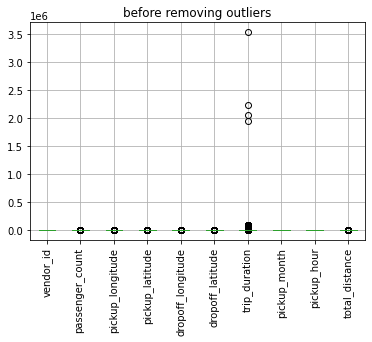

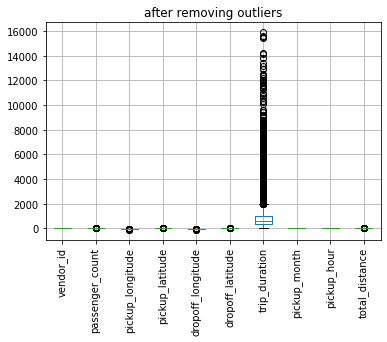

In [36]:
#outliers removal
taxi=remove_outliers(taxi)

In [ ]:
taxi.shape

(1357455, 13)

In [ ]:
def convert_weekday(x):
  if x in ['Monday','Tuesday','Wednesday','Thursday','Friday']:
    x = 0
    return x
  else:
    x = 1
    return x

In [ ]:
taxi['pickup_is_weekend'] = taxi['pickup_weekday'].apply(convert_weekday)
taxi['dropoff_is_weekend'] = taxi['dropoff_weekday'].apply(convert_weekday)

In [ ]:
def convert_pickup_hour(x):
  if x in [0,1,2,3,4,5,6]:
    x = 'mid_night'
    return x
  elif x in [7,8,9,10,11,12]:
    x = 'office_time'
    return x
  elif x in [13,14,15,16,17,18]:
    x = 'lunch_time'
    return x
  else:
    x = 'Evening_time'
    return x

In [ ]:
taxi['pickup_shift'] = taxi['pickup_hour'].apply(convert_pickup_hour)

In [ ]:
taxi.head()

,vendor_id,passenger_count,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,store_and_fwd_flag,trip_duration,pickup_weekday,dropoff_weekday,pickup_month,pickup_hour,total_distance,pickup_is_weekend,dropoff_is_weekend,pickup_shift
0,2,1,-73.982155,40.767937,-73.964630,40.765602,N,455,Monday,Monday,3,17,0.017680,0,0,lunch_time
1,1,1,-73.980415,40.738564,-73.999481,40.731152,N,663,Sunday,Sunday,6,0,0.020456,1,1,mid_night
2,2,1,-73.979027,40.763939,-74.005333,40.710087,N,2124,Tuesday,Tuesday,1,11,0.059934,0,0,office_time
3,2,1,-74.010040,40.719971,-74.012268,40.706718,N,429,Wednesday,Wednesday,4,19,0.013438,0,0,Evening_time
4,2,1,-73.973053,40.793209,-73.972923,40.782520,N,435,Saturday,Saturday,3,13,0.010690,1,1,lunch_time


In [ ]:
numeric_feature = taxi.describe().columns
numeric_feature

Index(['vendor_id', 'passenger_count', 'pickup_longitude', 'pickup_latitude',
       'dropoff_longitude', 'dropoff_latitude', 'trip_duration',
       'pickup_month', 'pickup_hour', 'total_distance', 'pickup_is_weekend',
       'dropoff_is_weekend'],
      dtype='object')

In [ ]:
#as dropoff_isweekend have high correlation with pickup_isweekend we drop dropoff_is_weekend

/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


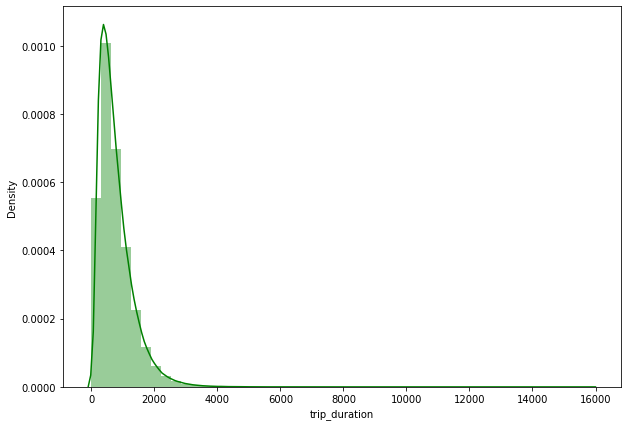

In [ ]:
# Now check the distribution of dependent variable
import seaborn as sns
fig = plt.figure(figsize=(10,7))
sns.distplot(taxi['trip_duration'], color = 'g')

/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


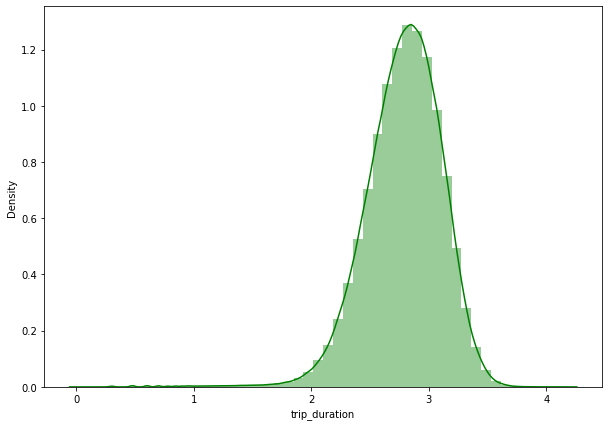

In [ ]:
fig = plt.figure(figsize=(10,7))
sns.distplot(np.log10(taxi['trip_duration']), color = 'g')

/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


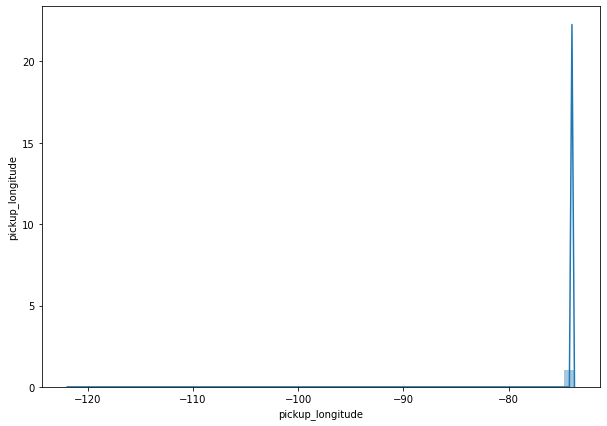

/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


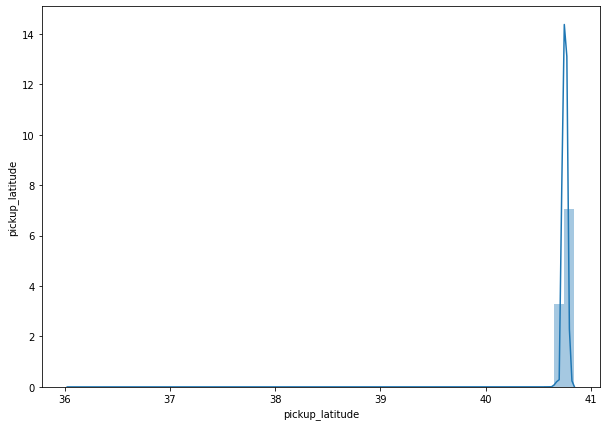

/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


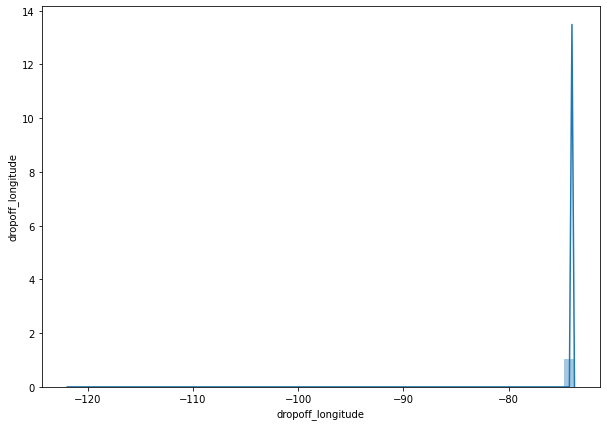

/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


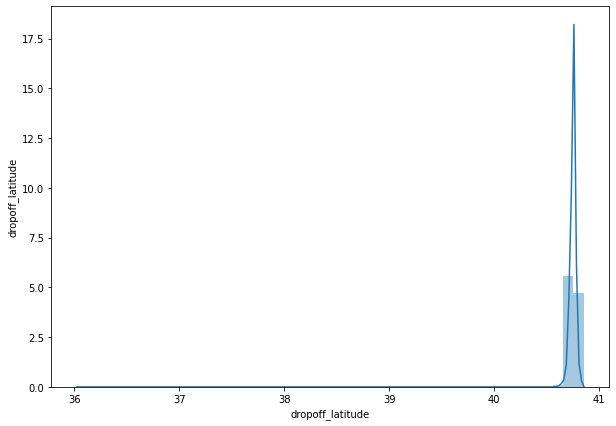

/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


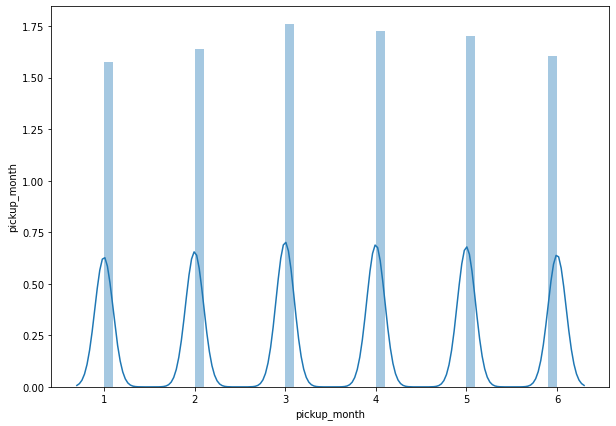

/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


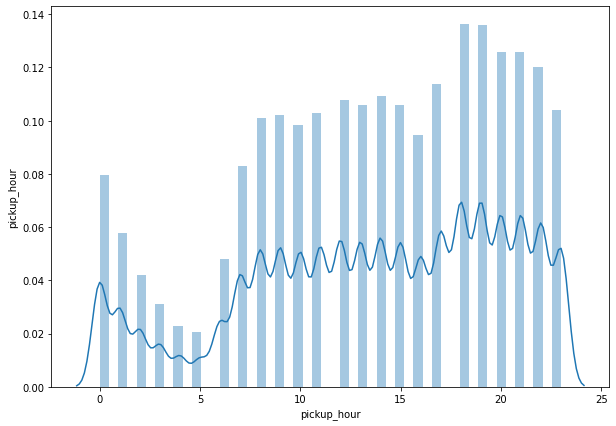

/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


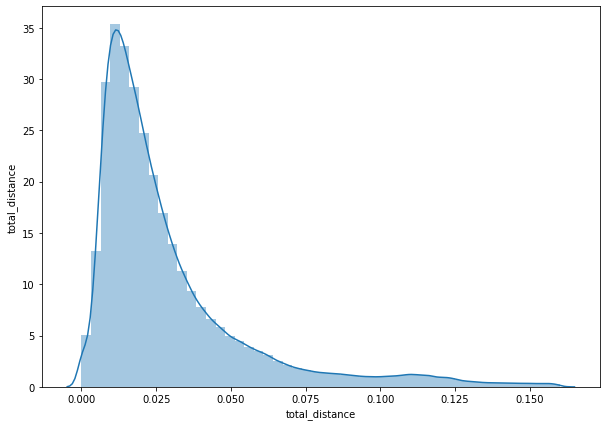

/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


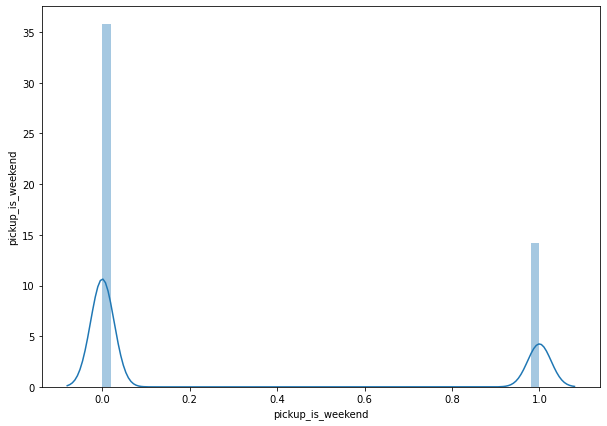

/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


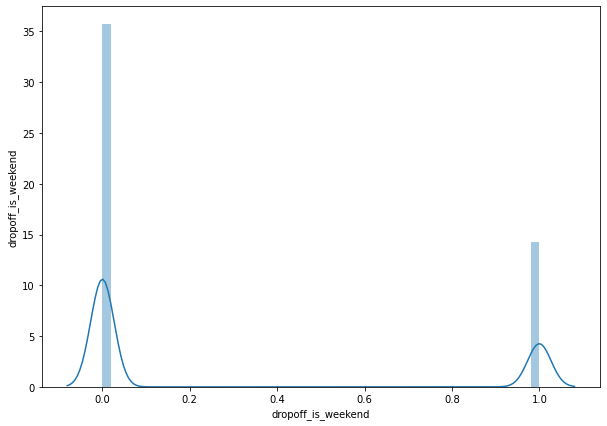

In [ ]:
for col in numeric_feature[1:]:
  if col not in ['passenger_count','trip_duration']:
    fig = plt.figure(figsize=(10,7))
    sns.distplot(taxi[col])
    plt.ylabel(col)
    plt.show()

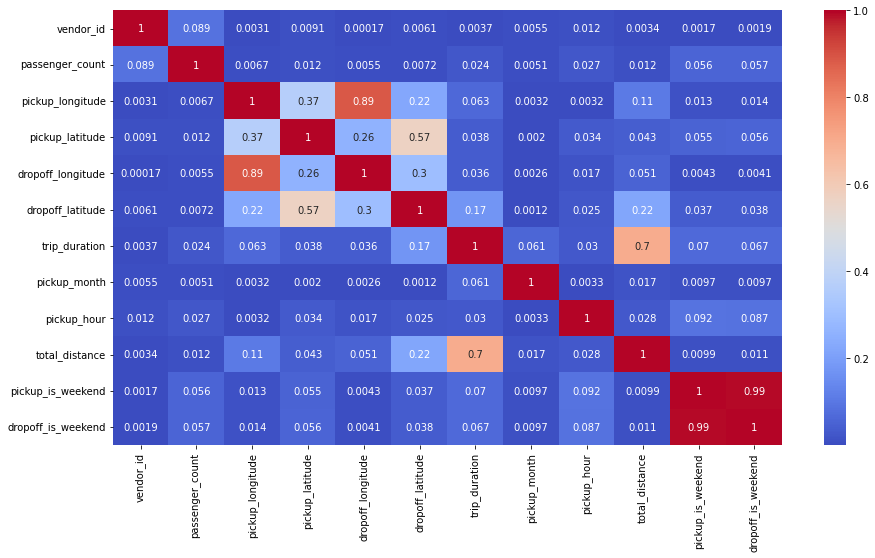

In [ ]:
#let's have a look at correlation of different attributes and remove multicollinearity
plt.figure(figsize=(15,8))
correlation = taxi.corr()
sns.heatmap(abs(correlation), annot=True, cmap='coolwarm')